# Zestaw 9. Page Rank

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## 1. Prosty ranking wierzchołków

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym.</i>

#### graf

In [2]:
def get_connected_graph(n):
    graph = nx.generators.directed.random_k_out_graph(n, n-2, 3)
    nodes = max(nx.strongly_connected_components(graph), key=len)
    connected_graph = nx.DiGraph()
    for node in nodes:
        for edge in graph.out_edges(node):
            connected_graph.add_edge(*edge)
    return connected_graph

In [3]:
def draw_graph(graph, pos):
    plt.figure(figsize=(10, 5))
    labels = {n: graph.nodes[n].get('weight', ' ') for n in graph.nodes}
    nx.draw(graph, pos=pos, with_labels=True, labels=labels, node_color='mediumslateblue', edge_color='silver')

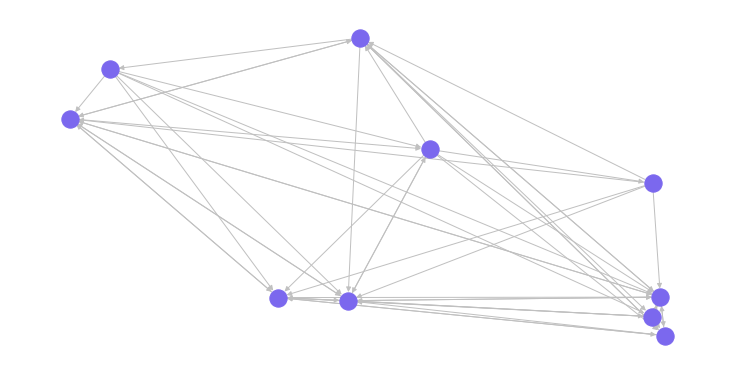

In [4]:
graph = get_connected_graph(10)
print(graph)
pos = nx.random_layout(graph)
draw_graph(graph, pos)

#### metoda potęgowa

In [5]:
def power_method(A, epsilon=1e-8, max_iteration=100):
    def norm_inf(x): return np.linalg.norm(x, np.inf)
    def normalize(x): return x/np.linalg.norm(x, ord=1)
    
    n = A.shape[0]
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = norm_inf(x)
    x /= max_x
    iteration = 1
    
    while iteration < max_iteration and not np.allclose(x, prev_x, atol=epsilon) and not np.allclose(x, -prev_x, atol=epsilon):
        x, prev_x = A @ x, x
        max_x = norm_inf(x)
        x /= max_x
        iteration += 1
        
    return normalize(x)

#### ranking

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym</i>

In [6]:
def simple_rank(graph, d=1):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
                
    r = power_method(d*A.T)
    
    for u in range(n):
        graph.nodes[nodes[u]]['weight'] = r[u]
        
    return graph, r

In [7]:
graph, rank = simple_rank(graph)

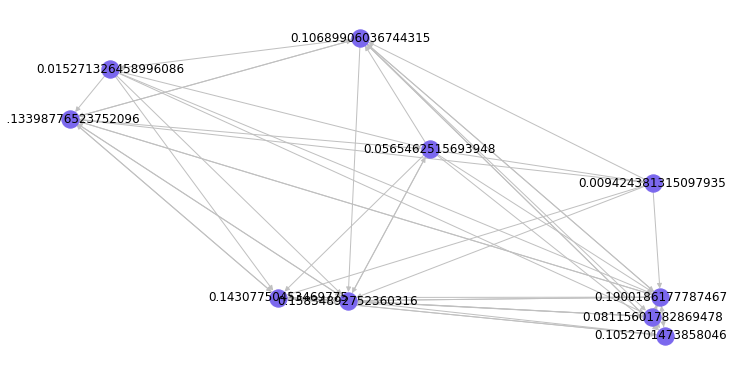

In [8]:
draw_graph(graph, pos)

#### testy

rank:  [0.14362723 0.11703648 0.05675765 0.09117724 0.14317271 0.04064497
 0.06552063 0.0654557  0.08240064 0.07819241 0.11601434]


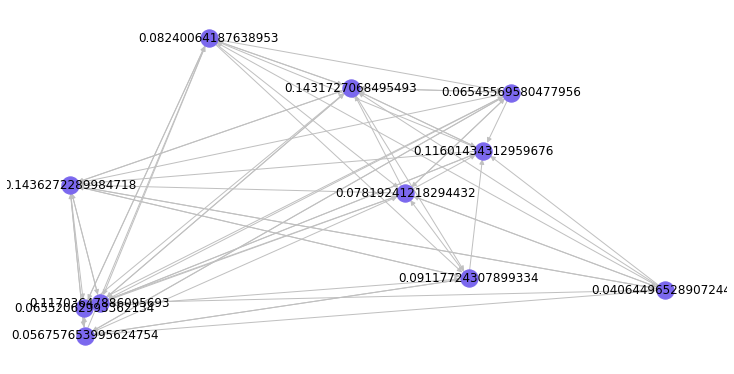

In [9]:
graph1 = get_connected_graph(11)
ranked_graph1, rank1 = simple_rank(graph1)
print('rank: ', rank1)
draw_graph(ranked_graph1, nx.random_layout(ranked_graph1))

rank:  [0.06321131 0.08281861 0.09309409 0.08572327 0.06152498 0.03173642
 0.05475985 0.03195117 0.02139003 0.06772037 0.06462849 0.03713488
 0.03091428 0.03136046 0.05178622 0.0549168  0.04798553 0.01769557
 0.0313588  0.03828886]


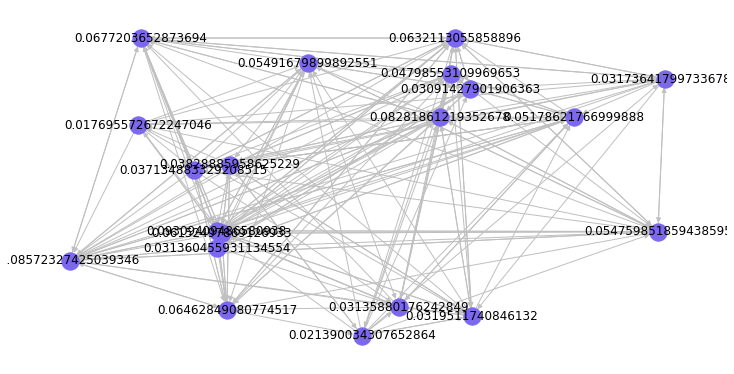

In [10]:
graph2 = get_connected_graph(20)
ranked_graph2, rank2 = simple_rank(graph2)
print('rank: ', rank2)
draw_graph(ranked_graph2, nx.random_layout(ranked_graph2))

rank:  [0.00516535 0.01322355 0.01270909 0.01548379 0.00987231 0.00934954
 0.01426797 0.01543686 0.00733414 0.01408038 0.01502022 0.01291647
 0.01151729 0.01473178 0.00451583 0.00626861 0.0090225  0.00962585
 0.01231941 0.01344236 0.01444389 0.0163382  0.00996737 0.00808351
 0.01605997 0.01056433 0.01238337 0.01615845 0.0173533  0.00433321
 0.01490732 0.01390636 0.01476722 0.01665108 0.01291427 0.01713611
 0.00629315 0.00475185 0.01352022 0.00977819 0.0105852  0.01306979
 0.00483682 0.01376984 0.00771486 0.01159593 0.01195073 0.00628259
 0.00527127 0.00967016 0.00936384 0.00837704 0.01477578 0.01422901
 0.01021542 0.01375159 0.01272846 0.01071658 0.01467495 0.01637005
 0.00903124 0.01093363 0.01465286 0.00387998 0.00389989 0.00990168
 0.0104181  0.00602828 0.01231919 0.00885582 0.01319653 0.01305667
 0.01229913 0.00780226 0.01023534 0.00723353 0.00369836 0.00869643
 0.00875349 0.00553721 0.00401465 0.00459779 0.01021894 0.00940678
 0.00409583 0.00523821 0.00788297 0.00933331 0.00703072

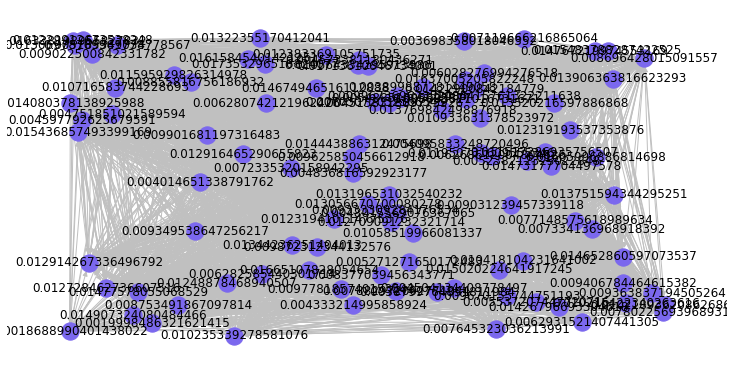

In [19]:
graph3 = get_connected_graph(100)
ranked_graph3, rank3 = simple_rank(graph3)
print('rank: ', rank3)
draw_graph(ranked_graph3, nx.random_layout(ranked_graph3))

## 2. Page Rank

In [20]:
def remove_dangling(graph):
    for node in graph.nodes():
        if len(graph.out_edges[node]):
            graph.remove_node(node)

In [21]:
def page_rank(graph, d, e, add_labels=False):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
    
    
    B = d*A + (1-d)*e
    
    r = power_method(B.T)
    
    if add_labels:
        for i in range(n):
            graph.nodes[nodes[i]]['weight'] = r[i]
    
    return graph, {nodes[i]: round(r[i], 3) for i in range(n)}

In [22]:
def nx_page_rank(graph, d, e):
    nodes = list(graph.nodes())
    personalization = {nodes[i]: e[i] for i in range(graph.number_of_nodes())}
    rank = nx.algorithms.link_analysis.pagerank_alg.pagerank(graph, alpha=d, personalization=personalization)
    return {key: round(rank[key], 3) for key in rank}

## Testy

zrobić dla grafu pełnego?

In [43]:
def test_page_rank(graph, e=None, d=0.85):
    if e is None:
        n = graph.number_of_nodes()
        e = np.ones(n)/n
        
    graph, rank = page_rank(graph, d, e)

    print('e: ', e)
    print('rank: ', rank)
    print('nx rank: ', nx_page_rank(graph, d, e))
    print('max rank: ', max(rank.items(), key=lambda x: x[1]))

#### dla różnych wektorów e

dla e o rozkładzie jednopunktowym

In [44]:
n = graph.number_of_nodes()
test_page_rank(graph, np.ones(n)/n)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.106, 8: 0.103, 2: 0.082, 1: 0.128, 4: 0.177, 3: 0.151, 6: 0.028, 7: 0.063, 9: 0.139, 5: 0.024}
nx rank:  {0: 0.106, 8: 0.103, 2: 0.082, 1: 0.128, 4: 0.177, 3: 0.151, 6: 0.028, 7: 0.063, 9: 0.139, 5: 0.024}
max rank:  (4, 0.177)


wektor e z przewagą wartości dla jednego z wierzchołków

In [45]:
n = graph.number_of_nodes()
e = np.zeros(n)
e[0] = 1

test_page_rank(graph, e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.245, 8: 0.092, 2: 0.079, 1: 0.113, 4: 0.156, 3: 0.133, 6: 0.03, 7: 0.043, 9: 0.104, 5: 0.006}
nx rank:  {0: 0.245, 8: 0.092, 2: 0.079, 1: 0.113, 4: 0.156, 3: 0.133, 6: 0.03, 7: 0.043, 9: 0.104, 5: 0.006}
max rank:  (0, 0.245)


Wektor e reprezentuje prawdopodobieństwo odwiedzenia wierzchołków przez losowy skok. Dzięki niemu jesteśmy w stanie uwzględnić znane preferencje w rankingu i chociażby spersonalizować wynik wyszukiwania, pod względem interesujących kategorii.

#### dla różnych wartości d

In [46]:
test_page_rank(graph, d=0.9)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.106, 8: 0.104, 2: 0.082, 1: 0.13, 4: 0.181, 3: 0.153, 6: 0.024, 7: 0.061, 9: 0.14, 5: 0.019}
nx rank:  {0: 0.106, 8: 0.104, 2: 0.082, 1: 0.13, 4: 0.181, 3: 0.153, 6: 0.024, 7: 0.061, 9: 0.14, 5: 0.019}
max rank:  (4, 0.181)


In [47]:
test_page_rank(graph, d=0.85)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.106, 8: 0.103, 2: 0.082, 1: 0.128, 4: 0.177, 3: 0.151, 6: 0.028, 7: 0.063, 9: 0.139, 5: 0.024}
nx rank:  {0: 0.106, 8: 0.103, 2: 0.082, 1: 0.128, 4: 0.177, 3: 0.151, 6: 0.028, 7: 0.063, 9: 0.139, 5: 0.024}
max rank:  (4, 0.177)


In [48]:
test_page_rank(graph, d=0.75)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.105, 8: 0.102, 2: 0.084, 1: 0.124, 4: 0.168, 3: 0.146, 6: 0.036, 7: 0.067, 9: 0.135, 5: 0.033}
nx rank:  {0: 0.105, 8: 0.102, 2: 0.084, 1: 0.124, 4: 0.168, 3: 0.146, 6: 0.036, 7: 0.067, 9: 0.135, 5: 0.033}
max rank:  (4, 0.168)


In [49]:
test_page_rank(graph, d=0.6)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.104, 8: 0.1, 2: 0.086, 1: 0.119, 4: 0.154, 3: 0.138, 6: 0.049, 7: 0.073, 9: 0.13, 5: 0.047}
nx rank:  {0: 0.104, 8: 0.1, 2: 0.086, 1: 0.119, 4: 0.154, 3: 0.138, 6: 0.049, 7: 0.073, 9: 0.13, 5: 0.047}
max rank:  (4, 0.154)


In [50]:
test_page_rank(graph, d=0.5)

e:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
rank:  {0: 0.104, 8: 0.099, 2: 0.087, 1: 0.115, 4: 0.145, 3: 0.132, 6: 0.057, 7: 0.078, 9: 0.126, 5: 0.056}
nx rank:  {0: 0.104, 8: 0.099, 2: 0.087, 1: 0.115, 4: 0.145, 3: 0.132, 6: 0.057, 7: 0.078, 9: 0.126, 5: 0.056}
max rank:  (4, 0.145)


#### grafy z bazy Snap

In [54]:
def graph_from_file(file_name):
    graph = nx.DiGraph()
    with open(file_name, 'r') as f:
        for line in f:
            if line[0] == '#': continue
            u, v = line.split('\t')
            u = u.strip()
            v = v.strip()
            graph.add_edge(u, v)
    return graph

In [55]:
graph_wiki_vote = graph_from_file('Wiki-Vote.txt')

In [56]:
test_page_rank(graph_wiki_vote)

e:  [0.00014055 0.00014055 0.00014055 ... 0.00014055 0.00014055 0.00014055]
rank:  {'30': 0.0, '1412': 0.001, '3352': 0.002, '5254': 0.003, '5543': 0.001, '7478': 0.001, '3': 0.0, '28': 0.002, '39': 0.0, '54': 0.0, '108': 0.001, '152': 0.001, '178': 0.0, '182': 0.0, '214': 0.002, '271': 0.001, '286': 0.0, '300': 0.0, '348': 0.0, '349': 0.0, '371': 0.0, '567': 0.0, '581': 0.0, '584': 0.0, '586': 0.0, '590': 0.0, '604': 0.0, '611': 0.0, '8283': 0.0, '25': 0.0, '6': 0.0, '8': 0.0, '19': 0.0, '23': 0.0, '29': 0.0, '33': 0.0, '35': 0.001, '50': 0.0, '55': 0.001, '75': 0.0, '80': 0.0, '86': 0.001, '94': 0.0, '127': 0.0, '154': 0.0, '192': 0.0, '224': 0.0, '226': 0.0, '246': 0.0, '252': 0.0, '255': 0.0, '257': 0.0, '261': 0.0, '273': 0.0, '280': 0.0, '282': 0.001, '299': 0.001, '302': 0.0, '306': 0.0, '308': 0.0, '310': 0.0, '322': 0.0, '325': 0.0, '339': 0.0, '356': 0.0, '358': 0.0, '363': 0.0, '370': 0.0, '373': 0.0, '377': 0.0, '379': 0.0, '407': 0.001, '415': 0.0, '422': 0.0, '428': 0.0, 

nx rank:  {'30': 0.0, '1412': 0.001, '3352': 0.002, '5254': 0.002, '5543': 0.001, '7478': 0.001, '3': 0.0, '28': 0.002, '39': 0.0, '54': 0.0, '108': 0.0, '152': 0.001, '178': 0.0, '182': 0.0, '214': 0.002, '271': 0.001, '286': 0.0, '300': 0.0, '348': 0.0, '349': 0.0, '371': 0.0, '567': 0.0, '581': 0.0, '584': 0.0, '586': 0.0, '590': 0.0, '604': 0.0, '611': 0.0, '8283': 0.0, '25': 0.0, '6': 0.0, '8': 0.0, '19': 0.0, '23': 0.0, '29': 0.0, '33': 0.0, '35': 0.001, '50': 0.0, '55': 0.001, '75': 0.0, '80': 0.0, '86': 0.001, '94': 0.0, '127': 0.0, '154': 0.0, '192': 0.0, '224': 0.0, '226': 0.0, '246': 0.0, '252': 0.0, '255': 0.0, '257': 0.0, '261': 0.0, '273': 0.0, '280': 0.0, '282': 0.001, '299': 0.001, '302': 0.0, '306': 0.0, '308': 0.0, '310': 0.0, '322': 0.0, '325': 0.0, '339': 0.0, '356': 0.0, '358': 0.0, '363': 0.0, '370': 0.0, '373': 0.0, '377': 0.0, '379': 0.0, '407': 0.001, '415': 0.0, '422': 0.0, '428': 0.0, '439': 0.0, '488': 0.0, '514': 0.0, '545': 0.0, '549': 0.001, '560': 0.0, '

## Wnioski